In [ ]:
# Cargue de librerías
import pandas as pd
from prophet import Prophet
import os
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import hashlib

In [ ]:
# ruta de archivos
files = os.listdir("c:\\archivos\proyecto")
os.chdir(r'C:\archivos\proyecto')

df_total = pd.read_csv('ind_urgencias_final_2023_filtrado.txt', sep=';')

In [ ]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82416 entries, 0 to 82415
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   FECHA_LLEGADA              82416 non-null  object
 1   FECHA_TRIAGE               82416 non-null  object
 2   FECHA_INGRESO              82416 non-null  object
 3   FECHA_ATENCION             82416 non-null  object
 4   TIEMPO_DGTURNO_A_TRIAGE    82416 non-null  object
 5   TIEMPO_TRIAGE_A_INGRESO    82416 non-null  object
 6   TIEMPO_INGRESO_A_CONSULTA  82416 non-null  object
 7   TIEMPO_TOTAL               82416 non-null  object
 8   Tiempo_Minutos_Total       82416 non-null  object
 9   CENTRO_ATENCION            82416 non-null  object
 10  CLASIFICACION_TRIAGE       82416 non-null  int64 
 11  PACIENTE_#_DOCUMENTO       82416 non-null  object
 12  EDAD                       82416 non-null  int64 
 13  EDAD_RANGO                 82416 non-null  object
 14  SEXO  

In [ ]:
# convertir a variables categoricas
#df_total['Turnos'] = df_total['Turnos'].astype('category')
#df_total['DIA_SEMANA'] = df_total['DIA_SEMANA'].astype('category')
df_total['CENTRO_ATENCION'] = df_total['CENTRO_ATENCION'].astype('category')

In [ ]:
# Seleccionar las columnas de interés
#df = df_hearth[['DIA_SEMANA', 'Tiempo_Minutos_Total']]

data = df_total[['Tiempo_Minutos_Total','CENTRO_ATENCION','FECHA_LLEGADA','PACIENTE_#_DOCUMENTO','Turnos','MEDICO']]

In [ ]:
# reemplazar datos para convertirlos enteros
data['Tiempo_Minutos_Total'] = data['Tiempo_Minutos_Total'].str.replace(',', '.', regex=True)
data["Tiempo_Minutos_Total"] = pd.to_numeric(data["Tiempo_Minutos_Total"],errors='coerce')
data['Turnos'] = data['Turnos'].str.replace('MADRUGADA', '4', regex=True)
data['Turnos'] = data['Turnos'].str.replace('MAÑANA', '1', regex=True)
data['Turnos'] = data['Turnos'].str.replace('TARDE', '2', regex=True)
data['Turnos'] = data['Turnos'].str.replace('NOCHE', '3', regex=True)

C:\Users\Victor.Gomez\AppData\Local\Temp\ipykernel_8704\2942042221.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Tiempo_Minutos_Total'] = data['Tiempo_Minutos_Total'].str.replace(',', '.', regex=True)
C:\Users\Victor.Gomez\AppData\Local\Temp\ipykernel_8704\2942042221.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Tiempo_Minutos_Total"] = pd.to_numeric(data["Tiempo_Minutos_Total"],errors='coerce')
C:\Users\Victor.Gomez\AppData\Local\Temp\ipykernel_8704\2942042221.py:4: SettingWithCopyW

In [ ]:
# Para ver todas las filas que tienen valores faltantes -- revisar y eliminar filas
is_NaN = data.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = data[row_has_NaN]
rows_with_NaN.head(100)

,Tiempo_Minutos_Total,CENTRO_ATENCION,FECHA_LLEGADA,PACIENTE_#_DOCUMENTO,Turnos,MEDICO


In [ ]:
data

,Tiempo_Minutos_Total,CENTRO_ATENCION,FECHA_LLEGADA,PACIENTE_#_DOCUMENTO,Turnos,MEDICO
0,39.73,TN,2023-01-01 01:20:23.853,1007228378,3,11065
1,33.12,ME,2023-01-01 01:29:46.050,1000003681,3,8861
2,14.77,UC,2023-01-01 03:15:35.623,1007454009,3,5855
3,31.40,UC,2023-01-01 05:54:53.563,1022997183,3,11072
4,173.80,TN,2023-01-01 06:37:27.237,1013671529,3,1239
...,...,...,...,...,...,...
82411,84.90,ME,2023-09-18 04:44:41.970,1010242518,3,7844
82412,83.75,ME,2023-09-18 06:17:00.573,93357619,3,6204
82413,125.83,ME,2023-09-18 06:21:37.273,41372387,3,9951
82414,62.92,UB,2023-09-18 06:25:33.483,1000807249,3,4030


In [ ]:
# Anonimizar datos sensibles
# Crear un diccionario para asignar valores únicos
unique_dict = {}
counter = 1  # Contador inicial

# Función para asignar valores únicos
def assign_unique_value(value):
    global counter  # Usa 'global' en lugar de 'nonlocal'
    if value in unique_dict:
        return unique_dict[value]
    unique_dict[value] = counter
    counter += 1
    return unique_dict[value]

# Reemplazar PACIENTE_DOCUMENTO por valores únicos
data['PACIENTE_#_DOCUMENTO'] = data['PACIENTE_#_DOCUMENTO'].apply(assign_unique_value)

# Crear un diccionario para asignar valores únicos
unique_dict = {}
counter = 1  # Contador inicial

# Función para asignar valores únicos
def assign_unique_value(value):
    global counter  # Usa 'global' en lugar de 'nonlocal'
    if value in unique_dict:
        return unique_dict[value]
    unique_dict[value] = counter
    counter += 1
    return unique_dict[value]

# Reemplazar MEDICO por valores únicos
data['MEDICO'] = data['MEDICO'].apply(assign_unique_value)



C:\Users\Victor.Gomez\AppData\Local\Temp\ipykernel_8704\3498531685.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['PACIENTE_#_DOCUMENTO'] = data['PACIENTE_#_DOCUMENTO'].apply(assign_unique_value)
C:\Users\Victor.Gomez\AppData\Local\Temp\ipykernel_8704\3498531685.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MEDICO'] = data['MEDICO'].apply(assign_unique_value)


In [ ]:
data

,Tiempo_Minutos_Total,CENTRO_ATENCION,FECHA_LLEGADA,PACIENTE_#_DOCUMENTO,Turnos,MEDICO
0,39.73,TN,2023-01-01 01:20:23.853,1,3,1
1,33.12,ME,2023-01-01 01:29:46.050,2,3,2
2,14.77,UC,2023-01-01 03:15:35.623,3,3,3
3,31.40,UC,2023-01-01 05:54:53.563,4,3,4
4,173.80,TN,2023-01-01 06:37:27.237,5,3,5
...,...,...,...,...,...,...
82411,84.90,ME,2023-09-18 04:44:41.970,62211,3,49
82412,83.75,ME,2023-09-18 06:17:00.573,63445,3,11
82413,125.83,ME,2023-09-18 06:21:37.273,63446,3,43
82414,62.92,UB,2023-09-18 06:25:33.483,63447,3,21


In [ ]:
data.to_csv('urgencias.txt', sep=';', index=False)

C:\Users\Victor.Gomez\AppData\Local\Temp\ipykernel_8704\4116202701.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['FECHA_LLEGADA'] = pd.to_datetime(data['FECHA_LLEGADA'])
C:\Users\Victor.Gomez\AppData\Local\Temp\ipykernel_8704\4116202701.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'Mes'] = data['FECHA_LLEGADA'].dt.month
C:\Users\Victor.Gomez\AppData\Local\Temp\ipykernel_8704\4116202701.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

Tiempo de espera predicho: 74.59235000000004 minutos


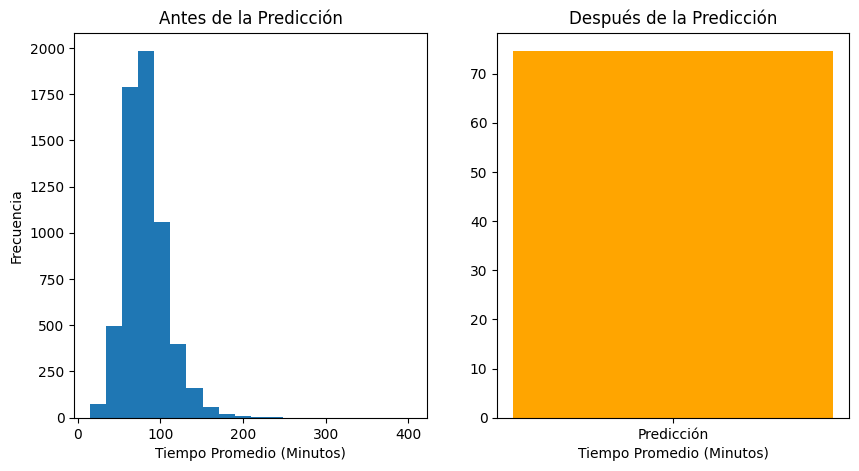

Tiempo de espera predicho: 74.59235000000004 minutos


In [ ]:
##  ok version 1

# Preprocesar los datos
data['FECHA_LLEGADA'] = pd.to_datetime(data['FECHA_LLEGADA'])
#data['Mes'] = data['FECHA_LLEGADA'].dt.month
#data['Día'] = data['FECHA_LLEGADA'].dt.day
#data['Día de la Semana'] = data['FECHA_LLEGADA'].dt.dayofweek
#data['HOUR'] = data['FECHA_LLEGADA'].dt.hour


# Preprocesar los datos

#data.loc[:, 'FECHA_LLEGADA'] = pd.to_datetime(data['FECHA_LLEGADA'])
data.loc[:, 'Mes'] = data['FECHA_LLEGADA'].dt.month
data.loc[:, 'Día'] = data['FECHA_LLEGADA'].dt.day
data.loc[:, 'DIA_SEMANA'] = data['FECHA_LLEGADA'].dt.dayofweek
data.loc[:, 'HOUR'] = data['FECHA_LLEGADA'].dt.hour

# quitar registros malos

# Calcular la mediana
median = data['Tiempo_Minutos_Total'].median()

# Corregir valores atípicos
data.loc[data['Tiempo_Minutos_Total'] > 420, 'Tiempo_Minutos_Total'] = median
data.loc[data['Tiempo_Minutos_Total'] < 0, 'Tiempo_Minutos_Total'] = median

# Calcular el tiempo promedio por grupo
tiempo_promedio = data.groupby(['Mes', 'Día', 'DIA_SEMANA', 'HOUR'])['Tiempo_Minutos_Total'].median().reset_index()

# Crear un modelo de regresión (Random Forest)
X = tiempo_promedio[['Mes', 'Día', 'DIA_SEMANA', 'HOUR']]
y = tiempo_promedio['Tiempo_Minutos_Total']
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Realizar predicciones para diferentes valores
nuevos_datos = pd.DataFrame({
    'Mes': [1,2,3,4,5,6,7],
    'Día': [10,11,12,13,14,15,16],
    'DIA_SEMANA': [1,2,3,4,5,6,7],
    'HOUR': [7,8,9,10,11,12,13]
})

tiempo_espera_predicho = model.predict(nuevos_datos)
print(f"Tiempo de espera predicho: {tiempo_espera_predicho[0]} minutos")

# Visualización (antes y después)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Antes de la Predicción")
plt.hist(tiempo_promedio['Tiempo_Minutos_Total'], bins=20)
plt.xlabel("Tiempo Promedio (Minutos)")
plt.ylabel("Frecuencia")
plt.subplot(1, 2, 2)
plt.title("Después de la Predicción")
plt.bar(["Predicción"], [tiempo_espera_predicho[0]], color='orange')
plt.xlabel("Tiempo Promedio (Minutos)")
plt.show()

print(f"Tiempo de espera predicho: {tiempo_espera_predicho[0]} minutos")


In [ ]:
data

,Tiempo_Minutos_Total,CENTRO_ATENCION,FECHA_LLEGADA,PACIENTE_#_DOCUMENTO,Turnos,MEDICO,Mes,Día,DIA_SEMANA,HOUR
0,39.73,TN,2023-01-01 01:20:23.853,1,3,1,1,1,6,1
1,33.12,ME,2023-01-01 01:29:46.050,2,3,2,1,1,6,1
2,14.77,UC,2023-01-01 03:15:35.623,3,3,3,1,1,6,3
3,31.40,UC,2023-01-01 05:54:53.563,4,3,4,1,1,6,5
4,173.80,TN,2023-01-01 06:37:27.237,5,3,5,1,1,6,6
...,...,...,...,...,...,...,...,...,...,...
82411,84.90,ME,2023-09-18 04:44:41.970,62211,3,49,9,18,0,4
82412,83.75,ME,2023-09-18 06:17:00.573,63445,3,11,9,18,0,6
82413,125.83,ME,2023-09-18 06:21:37.273,63446,3,43,9,18,0,6
82414,62.92,UB,2023-09-18 06:25:33.483,63447,3,21,9,18,0,6


C:\Users\Victor.Gomez\AppData\Local\Temp\ipykernel_8704\3379508475.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['FECHA_LLEGADA'] = pd.to_datetime(data['FECHA_LLEGADA'])


Tiempo de espera predicho: 74.59235000000004 minutos


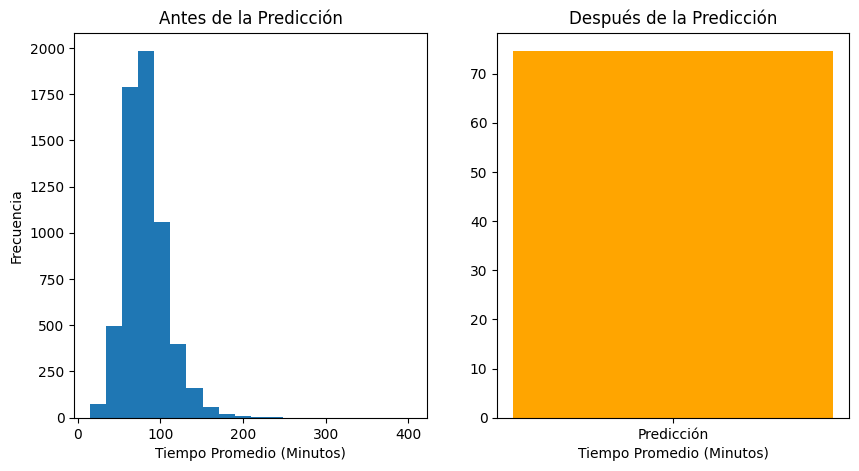

Tiempo de espera predicho: 74.59235000000004 minutos


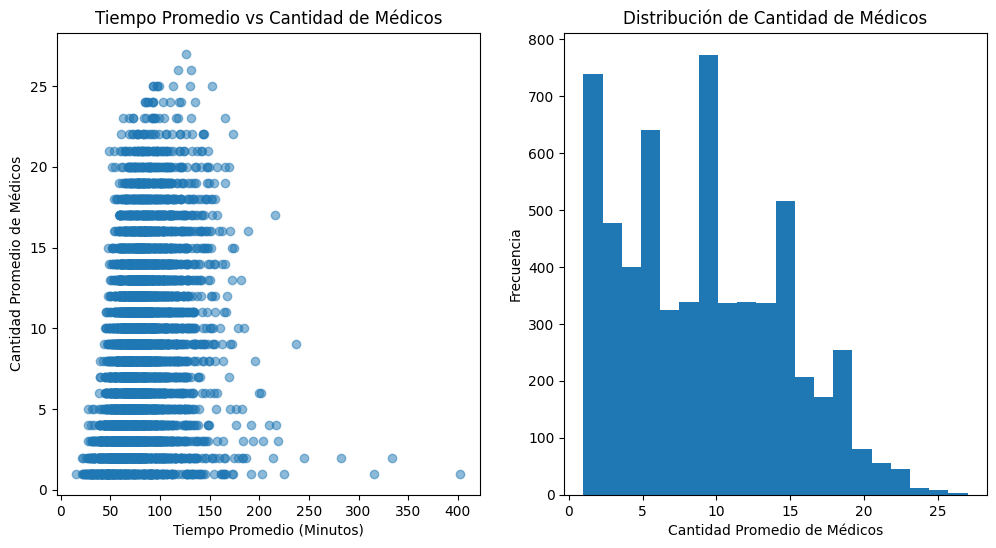

In [ ]:
# version 2 - tiempo promedio
# Preprocesar los datos
# Preprocesar los datos
data['FECHA_LLEGADA'] = pd.to_datetime(data['FECHA_LLEGADA'])

#data.loc[:, 'FECHA_LLEGADA'] = pd.to_datetime(data['FECHA_LLEGADA'])
data.loc[:, 'Mes'] = data['FECHA_LLEGADA'].dt.month
data.loc[:, 'Día'] = data['FECHA_LLEGADA'].dt.day
data.loc[:, 'DIA_SEMANA'] = data['FECHA_LLEGADA'].dt.dayofweek
data.loc[:, 'HOUR'] = data['FECHA_LLEGADA'].dt.hour

# quitar registros malos

# Calcular la mediana
median = data['Tiempo_Minutos_Total'].median()

# Corregir valores atípicos
data.loc[data['Tiempo_Minutos_Total'] > 420, 'Tiempo_Minutos_Total'] = median
data.loc[data['Tiempo_Minutos_Total'] < 0, 'Tiempo_Minutos_Total'] = median

# Calcular el total medicos
medico_contador = data.groupby(['Mes', 'Día', 'DIA_SEMANA', 'HOUR'])['MEDICO'].count().reset_index()

# Calcular el medico promedio  por grupo
medico_promedio = data.groupby(['Mes', 'Día', 'DIA_SEMANA', 'HOUR'])['MEDICO'].nunique().reset_index()
medico_promedio['Promedio_Medicos'] = medico_contador['MEDICO'] / medico_promedio['MEDICO']

# Crear un modelo de regresión (Random Forest)
X = tiempo_promedio[['Mes', 'Día', 'DIA_SEMANA', 'HOUR']]
y = tiempo_promedio['Tiempo_Minutos_Total']
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Realizar predicciones para diferentes valores
nuevos_datos = pd.DataFrame({
    'Mes': [1,2,3,4,5,6,7],
    'Día': [10,11,12,13,14,15,16],
    'DIA_SEMANA': [1,2,3,4,5,6,7],
    'HOUR': [7,8,9,10,11,12,13]
})

tiempo_espera_predicho = model.predict(nuevos_datos)
print(f"Tiempo de espera predicho: {tiempo_espera_predicho[0]} minutos")

# Visualización (antes y después)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Antes de la Predicción")
plt.hist(tiempo_promedio['Tiempo_Minutos_Total'], bins=20)
plt.xlabel("Tiempo Promedio (Minutos)")
plt.ylabel("Frecuencia")
plt.subplot(1, 2, 2)
plt.title("Después de la Predicción")
plt.bar(["Predicción"], [tiempo_espera_predicho[0]], color='orange')
plt.xlabel("Tiempo Promedio (Minutos)")
plt.show()

print(f"Tiempo de espera predicho: {tiempo_espera_predicho[0]} minutos")



# Comparar Tiempo_Minutos_Total y Cantidad_Medicos
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Tiempo Promedio vs Cantidad de Médicos")
plt.scatter(tiempo_promedio['Tiempo_Minutos_Total'], medico_promedio['MEDICO'], alpha=0.5)
plt.xlabel("Tiempo Promedio (Minutos)")
plt.ylabel("Cantidad Promedio de Médicos")

plt.subplot(1, 2, 2)
plt.title("Distribución de Cantidad de Médicos")
plt.hist(medico_promedio['MEDICO'], bins=20)
plt.xlabel("Cantidad Promedio de Médicos")
plt.ylabel("Frecuencia")

plt.show()

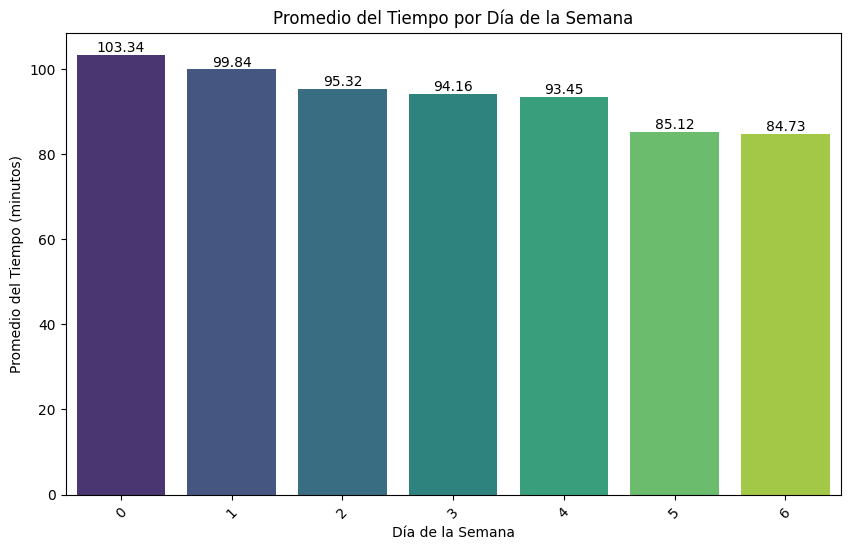

In [ ]:
import seaborn as sns

# Agrupar por día de la semana y calcular el promedio del Tiempo_total_minutos en cada grupo
promedio_tiempo_por_grupo =data.groupby(['DIA_SEMANA'])['Tiempo_Minutos_Total'].mean().reset_index()

# Renombrar la columna del promedio
promedio_tiempo_por_grupo = promedio_tiempo_por_grupo.rename(columns={'Tiempo_Minutos_Total': 'Promedio_Tiempo'})

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=promedio_tiempo_por_grupo, x='DIA_SEMANA', y='Promedio_Tiempo', palette='viridis')
plt.xlabel('Día de la Semana')
plt.ylabel('Promedio del Tiempo (minutos)')
plt.title('Promedio del Tiempo por Día de la Semana')
plt.xticks(rotation=45)

# Agregar etiquetas en las barras
for index, row in promedio_tiempo_por_grupo.iterrows():
    ax.annotate(str(round(row['Promedio_Tiempo'], 2)), (index, row['Promedio_Tiempo']), ha='center', va='bottom')
plt.show()

In [ ]:
print(f"Tiempo de espera predicho: {tiempo_espera_predicho[0]} minutos")
print(f"Tiempo de espera predicho: {tiempo_espera_predicho[1]} minutos")
print(f"Tiempo de espera predicho: {tiempo_espera_predicho[2]} minutos")
print(f"Tiempo de espera predicho: {tiempo_espera_predicho[3]} minutos")
print(f"Tiempo de espera predicho: {tiempo_espera_predicho[4]} minutos")

Tiempo de espera predicho: 74.59235000000004 minutos
Tiempo de espera predicho: 79.17985000000002 minutos
Tiempo de espera predicho: 85.67735000000002 minutos
Tiempo de espera predicho: 82.24480000000005 minutos
Tiempo de espera predicho: 66.15245000000002 minutos
